# Frequency and time-frequency sensors analysis


The objective is to show you how to explore the spectral content
of your data (frequency and time-frequency). Here we'll work on Epochs.

    Authors: Britta Westner, Alexandre Gramfort, Stefan Appelhoff, Richard Höchenberger, Denis A. Engemann
    License: BSD (3-clause)

In [107]:
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet

Set parameters



In [108]:
mne.set_log_level('error')

# Change the following path to where the folder ds000117 is on your disk
data_path = os.path.expanduser("~/Documents/teaching/practical_meeg_2022_data/ds000117")

epochs_fname = os.path.join(data_path,
    'derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss-epo.fif')

In [109]:
epochs = mne.read_epochs(epochs_fname, proj=True)

In [110]:
epochs.info

<Info | 25 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 70 EEG, 2 EOG
 custom_ref_applied: True
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 378
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: EOG-planar--0.200-0.200-PCA-01: on, EOG-axial-- ...
 sfreq: 300.0 Hz
 subject_info: 2 items (dict)
>

Frequency analysis
------------------

We start by exploring the frequence content of our epochs.



Let's first check out all channel types by averaging across epochs.

<li> The "bandwidth" parameter controls the spectral resolution of the multitaper. You can increase the resolution by chosing a narrower bandwidth at the cost of longer computation time.</li>


In [111]:
# Let's first compute the power spectrum

epochs_psd = epochs.compute_psd(method='multitaper', fmin=2., fmax=40., bandwidth=2.)

In [112]:
epochs_psd

<Power Spectrum (from Epochs, multitaper method) | 145 epochs × 376 channels × 95 freqs, 2.4-39.9 Hz>

In [113]:
%matplotlib qt
epochs_psd.plot();

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li> What is the name of the EEG channel with the highest power at high frequencies?</li>
    <li> What do the topographies at (roughly) 8-12 Hz look like?</li>
    </ul>
</div>

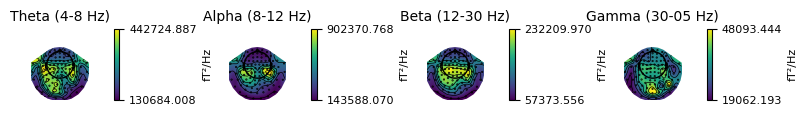

In [114]:
%matplotlib inline
bands = {'Theta (4-8 Hz)': (4, 8), 'Alpha (8-12 Hz)': (8, 12), 
         'Beta (12-30 Hz)': (12, 30), 'Gamma (30-05 Hz)': (30, 40)}
epochs_psd.plot_topomap(ch_type='mag',bands=bands, normalize=False, cmap='viridis');

The output of `compute_psd()` is a `Spectrum` object. We can index it similarly to `Epochs`

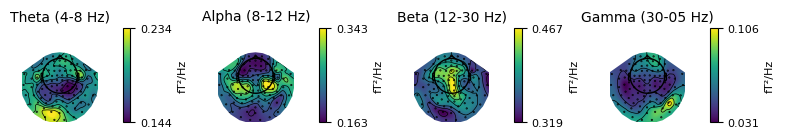

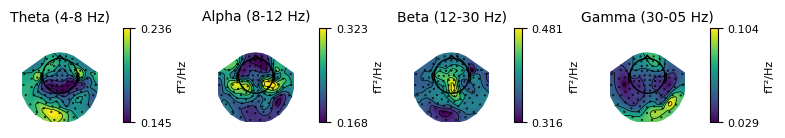

In [115]:
epochs_psd['face'].plot_topomap(ch_type='mag', bands=bands, normalize=True, cmap='viridis');
epochs_psd['scrambled'].plot_topomap(ch_type='mag', bands=bands, normalize=True, cmap='viridis');

<div class="alert alert-info">
    <b>REMARK</b>:
     <ul>
    <li>Sometimes it can be interesting  to consider the relative power, defined as the power in a given band divided by the total power. To explore this option, have a look at the "normalize" keyword. </li>
    </ul>
</div>

/Users/brittawe/Documents/code_dev/mnepython/mne/viz/utils.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


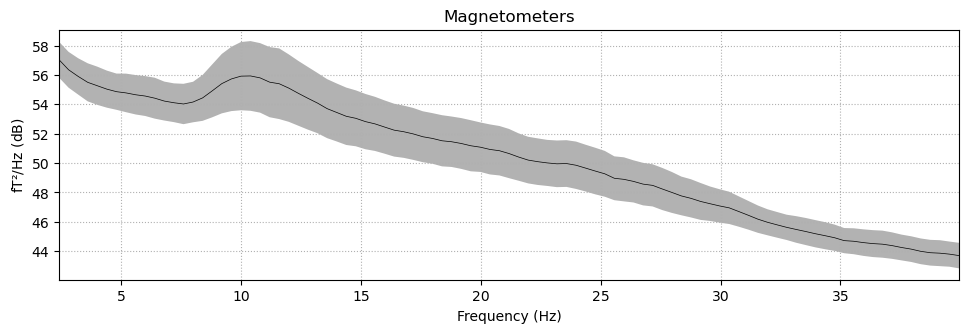

In [116]:
epochs_psd.plot(dB=True, picks='mag', average=True);

We can clearly see 2 peaks.

Notably, `mne.time_frequency.psd_welch` supports the keyword argument
``average``, which specifies how to estimate the PSD based on the individual
windowed segments. The default is ``average='mean'``, which simply calculates
the arithmetic mean across segments. Specifying ``average='median'``, in
contrast, returns the PSD based on the median of the segments (corrected for
bias relative to the mean), which is a more robust measure.

Lastly, we can also retrieve the unaggregated segments by passing
``average=None`` to `mne.time_frequency.psd_welch`. The dimensions of
the returned array are ``(n_epochs, n_sensors, n_freqs, n_segments)``.
This can be interesting when one is interested in computing statistics across segments or use custom functions for aggregation

## Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs.
We'll look at power and inter-trial coherence (ITC).

To this we'll use the function `mne.time_frequency.tfr_morlet`
but you can also use `mne.time_frequency.tfr_multitaper`
or `mne.time_frequency.tfr_stockwell`.

In [117]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([4, 30]), num=20)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

In [118]:
 # crop to remove edge artifacts
power.crop(-0.2, 1.6) 
itc.crop(-0.2, 1.6) 

<AverageTFR | time : [-0.200000, 1.600000], freq : [4.000000, 30.000000], nave : 145, channels : 376, ~17.4 MB>

Inspect power
-------------

<div class="alert alert-info"><h4>Note</h4><p>The generated figures are interactive. In the topo you can click
    on an image to visualize the data for one sensor.
    You can also select a portion in the time-frequency plane to
    obtain a topomap for a certain time-frequency region.</p></div>



In [119]:
baseline_mode = 'logratio'
baseline = (-0.2, 0)

In [120]:
%matplotlib qt
power.plot_topo(baseline=baseline, mode=baseline_mode, title='Average power');

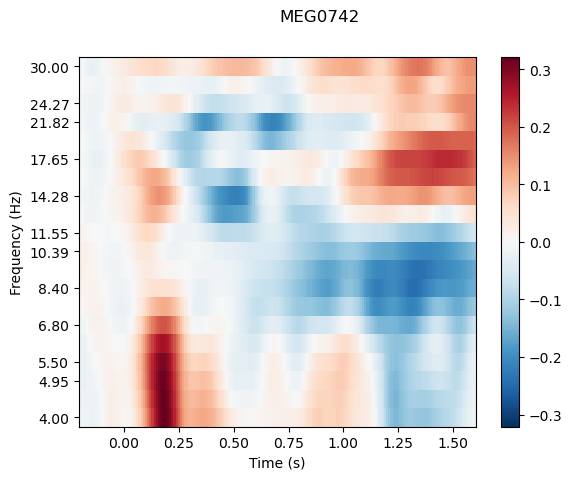

In [121]:
%matplotlib inline
power.plot([82], baseline=baseline, mode=baseline_mode, title=power.ch_names[82]);

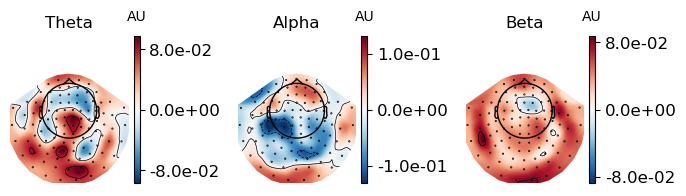

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(7, 4))
freqs = [(4, 7), (8, 12), (15, 30)]
titles = ['Theta', 'Alpha', 'Beta']

for ax, freq, title in zip(axes, freqs, titles):
    power.plot_topomap(ch_type='mag', tmin=0.5, tmax=1.5, 
                   fmin=freq[0], fmax=freq[1],
                   baseline=baseline, mode=baseline_mode, 
                   axes=ax, show=False, contours=1)
    ax.set_title(title)

mne.viz.tight_layout()
plt.show()

Joint Plot
----------
You can also create a joint plot showing both the aggregated TFR
across channels and topomaps at specific times and frequencies to obtain
a quick overview regarding oscillatory effects across time and space.



In [123]:
power.plot_topo?

Signature:
power.plot_topo(
    picks=None,
    baseline=None,
    mode='mean',
    tmin=None,
    tmax=None,
    fmin=None,
    fmax=None,
    vmin=None,
    vmax=None,
    layout=None,
    cmap='RdBu_r',
    title=None,
    dB=False,
    colorbar=True,
    layout_scale=0.945,
    show=True,
    border='none',
    fig_facecolor='k',
    fig_background=None,
    font_color='w',
    yscale='auto',
    verbose=None,
)
Docstring:
Plot TFRs in a topography with images.

Parameters
----------
picks : str | array-like | slice | None
    Channels to include. Slices and lists of integers will be interpreted as 
    channel indices. In lists, channel *type* strings (e.g., ``['meg', 
    'eeg']``) will pick channels of those types, channel *name* strings (e.g., 
    ``['MEG0111', 'MEG2623']`` will pick the given channels. Can also be the 
    string values "all" to pick all channels, or "data" to pick :term:`data 
    channels`. None (default) will pick good data channels. Note that channels 
  

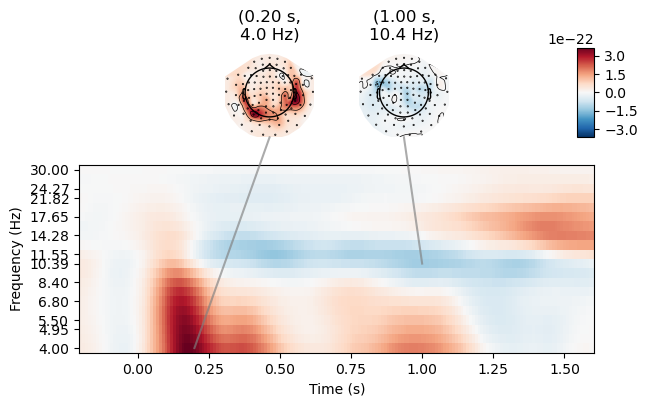

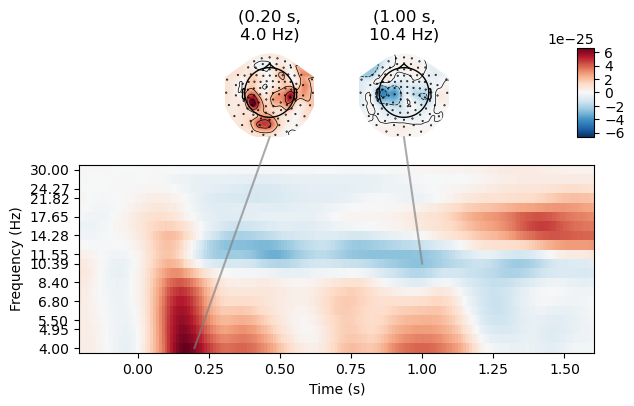

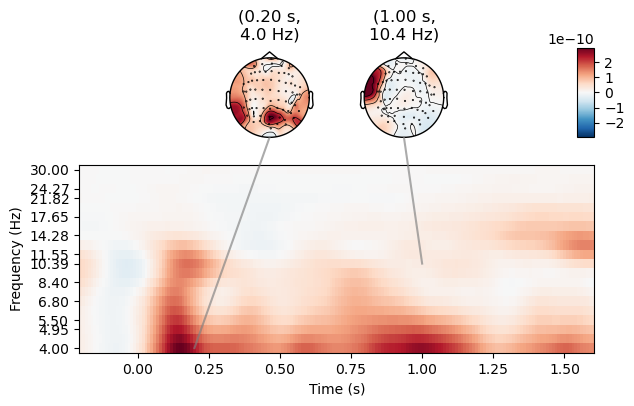

In [124]:
power.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.2, 4.), (1., 10.)]);

Inspect ITC
-----------



In [125]:
%matplotlib qt
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds');

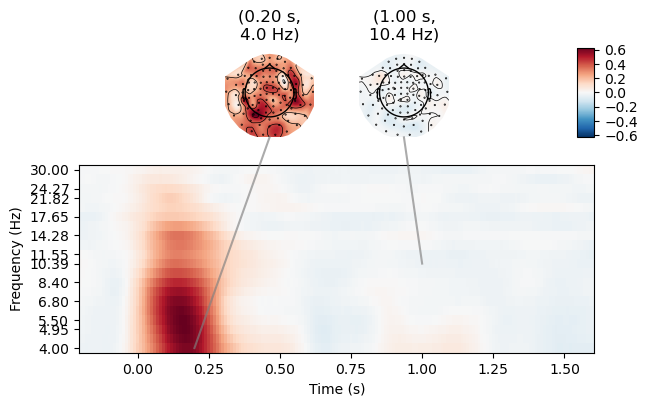

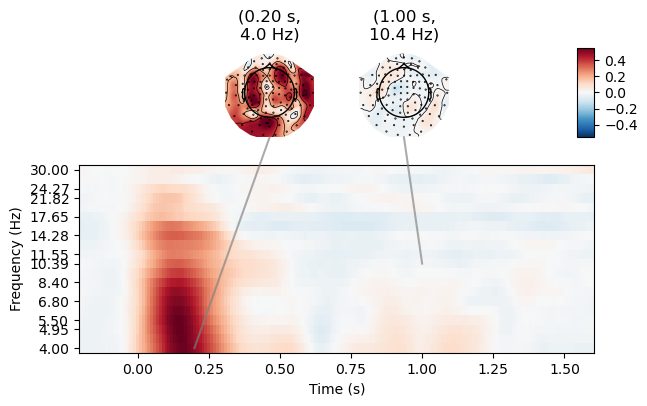

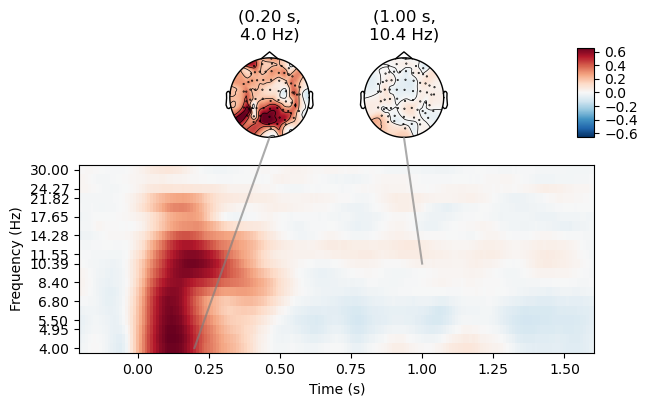

In [126]:
%matplotlib inline
itc.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.2, 4.), (1., 10.)]);

<div class="alert alert-info"><h4>Note</h4><p>Baseline correction can be applied to power or done in plots.
    To illustrate the baseline correction in plots, the next line is
    commented power.apply_baseline(baseline=(-0.5, 0), mode='logratio')</p></div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Visualize the inter-trial coherence values as topomaps as done with
     power</li>
    </ul>
</div>